In [1]:
#clean code for pulling data
import json
import os
import polars as pl
import time
from tqdm import tqdm
import ijson

def extract_blockchain_data(file_path, max_blocks=None, batch_size=1000):
    print(f"Processing {os.path.basename(file_path)}...")
    
    blocks_data = []
    transactions_data = []
    
    blocks_df_list = []
    transactions_df_list = []
    
    block_count = 0
    transaction_count = 0
    current_batch = 0
    
    try:
        with open(file_path, 'r') as f:
            parser = ijson.parse(f)
            
            current_block = None
            current_block_number = None
            current_block_hash = None
            current_block_timestamp = None
            current_block_transactions = 0
            array_depth = 0
            last_progress_time = time.time()
            inner_array_started = False
            
            item_type = None
            item_data = {}
            
            for prefix, event, value in parser:               
                if event == 'start_array':
                    array_depth += 1
                    if array_depth == 2:
                        inner_array_started = True
                        current_block_transactions = 0
                        
                elif event == 'end_array':
                    if array_depth == 2:
                        inner_array_started = False
                        if current_block is not None and len(blocks_data) > 0:
                            blocks_data[-1]['transaction_count'] = current_block_transactions
                    
                    array_depth -= 1
                    if array_depth == 1:
                        current_block = None
                        current_block_number = None
                        current_block_hash = None
                        current_block_timestamp = None
                
                if event == 'start_map':
                    item_data = {}
                    item_type = None
                elif event == 'map_key':
                    # check block or transaction
                    if value == 'number' and prefix.count('.') == 1:
                        item_type = 'block'
                    elif value == 'blockNumber' and prefix.count('.') == 1:
                        item_type = 'transaction'
                elif event == 'end_map':
                    if item_type == 'block':
                        # block data
                        block_summary = {
                            'block_number': item_data.get('number'),
                            'timestamp': item_data.get('timestamp'),
                            'gas_used': item_data.get('gasUsed'),
                            'gas_limit': item_data.get('gasLimit'),
                            'base_fee_per_gas': item_data.get('baseFeePerGas'),
                            'block_hash': item_data.get('hash'),
                            'transaction_count': 0,
                            'miner': item_data.get('miner'),
                            'size': item_data.get('size'),
                            'parent_hash': item_data.get('parentHash'),
                            'receipts_root': item_data.get('receiptsRoot'),
                            'state_root': item_data.get('stateRoot'),
                            'transactions_root': item_data.get('transactionsRoot')
                        }
                        blocks_data.append(block_summary)
                        current_block = block_summary
                        current_block_number = item_data.get('number')
                        current_block_hash = item_data.get('hash')
                        current_block_timestamp = item_data.get('timestamp')
                        block_count += 1
                        
                    elif item_type == 'transaction':
                        if inner_array_started:
                            current_block_transactions += 1
                        
                        tx_timestamp = None
                        if current_block_number == item_data.get('blockNumber'):
                            tx_timestamp = current_block_timestamp
                        
                        #  transaction data
                        transaction_summary = {
                            'tx_hash': item_data.get('hash'),
                            'block_number': item_data.get('blockNumber'),
                            'block_hash': item_data.get('blockHash'),
                            'timestamp': tx_timestamp,
                            'from_address': item_data.get('from'),
                            'to_address': item_data.get('to'),
                            'value': item_data.get('value'),
                            'gas': item_data.get('gas'),
                            'gas_price': item_data.get('gasPrice'),
                            'tx_type': item_data.get('type'),
                            'nonce': item_data.get('nonce'),
                            'transaction_index': item_data.get('transactionIndex'),
                            'chain_id': item_data.get('chainId')
                        }
                            
                        transactions_data.append(transaction_summary)
                        transaction_count += 1
                    
                    #  progress
                    current_time = time.time()
                    if current_time - last_progress_time > 30:
                        print(f"Processed {block_count} blocks and {transaction_count} transactions. Current batch: {current_batch}")
                        last_progress_time = current_time

                    if block_count > 0 and block_count % batch_size == 0 and len(blocks_data) > 0:
                        batch_blocks_df = pl.DataFrame(blocks_data)
                        batch_transactions_df = pl.DataFrame(transactions_data)
                        
                        blocks_df_list.append(batch_blocks_df)
                        transactions_df_list.append(batch_transactions_df)
                        
                        blocks_data = []
                        transactions_data = []
                        current_batch += 1
                        
                        print(f"Batch {current_batch} processed: {batch_size} blocks, {len(batch_transactions_df)} transactions")
                    
                    if max_blocks and block_count >= max_blocks:
                        break
                
                elif prefix.count('.') == 2 and event != 'start_array' and event != 'end_array':
                    field = prefix.split('.')[-1]
                    item_data[field] = value
            
            if len(blocks_data) > 0:
                batch_blocks_df = pl.DataFrame(blocks_data)
                batch_transactions_df = pl.DataFrame(transactions_data)
                
                blocks_df_list.append(batch_blocks_df)
                transactions_df_list.append(batch_transactions_df)
                
                print(f"Final batch processed: {len(blocks_data)} blocks, {len(transactions_data)} transactions")
            
            if blocks_df_list:
                blocks_df = pl.concat(blocks_df_list)
            else:
                blocks_df = pl.DataFrame()
                
            if transactions_df_list:
                transactions_df = pl.concat(transactions_df_list)
            else:
                transactions_df = pl.DataFrame()
            
            print(f"Completed processing {os.path.basename(file_path)}")
            print(f"Extracted {block_count} blocks and {transaction_count} transactions")

            #missing timestamp
            if not transactions_df.is_empty() and 'timestamp' in transactions_df.columns:
                missing_timestamps = transactions_df.filter(pl.col('timestamp').is_null()).height
                
                if missing_timestamps > 0 and not blocks_df.is_empty():
                    print(f"Filling in {missing_timestamps} missing timestamps...")
                    
                    block_timestamp_map = blocks_df.select(['block_number', 'timestamp']).unique().to_dict(as_series=False)
                    block_ts_dict = dict(zip(block_timestamp_map['block_number'], block_timestamp_map['timestamp']))
                    
                    def fill_timestamp(row):
                        if row['timestamp'] is None and row['block_number'] in block_ts_dict:
                            return block_ts_dict[row['block_number']]
                        return row['timestamp']
                    
                    transactions_df = transactions_df.with_columns(
                        pl.struct(['timestamp', 'block_number'])
                        .map_elements(lambda x: fill_timestamp(x), return_dtype=pl.Int64)
                        .alias('timestamp')
                    )
                    
                    # check missing timestamps
                    still_missing = transactions_df.filter(pl.col('timestamp').is_null()).height
                    if still_missing > 0:
                        print(f"Warning: {still_missing} transactions still missing timestamps")
                    else:
                        print("All timestamps filled successfully")
            
            return blocks_df, transactions_df
                
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return pl.DataFrame(), pl.DataFrame()

def process_multiple_files(file_list, max_blocks_per_file=None, batch_size=1000):
    all_blocks_list = []
    all_transactions_list = []
    
    for file_path in file_list:
        if os.path.exists(file_path):
            print(f"\nProcessing file {os.path.basename(file_path)}...")
            print(f"File size: {os.path.getsize(file_path) / (1024 * 1024):.2f} MB")
            
            try:
                blocks_df, transactions_df = extract_blockchain_data(
                    file_path, 
                    max_blocks=max_blocks_per_file,
                    batch_size=batch_size
                )
                
                if not blocks_df.is_empty():
                    all_blocks_list.append(blocks_df)
                if not transactions_df.is_empty():
                    all_transactions_list.append(transactions_df)
                    
            except KeyboardInterrupt:
                print("\nProcessing interrupted by user.")
                break
            except Exception as e:
                print(f"Error processing {file_path}: {str(e)}")
        else:
            print(f"File not found: {file_path}")
    
    if all_blocks_list:
        combined_blocks = pl.concat(all_blocks_list)
        # remove duplicates
        combined_blocks = combined_blocks.unique(subset=['block_number', 'block_hash'])
    else:
        combined_blocks = pl.DataFrame()
        
    if all_transactions_list:
        combined_transactions = pl.concat(all_transactions_list)
        # remove duplicates
        combined_transactions = combined_transactions.unique(subset=['tx_hash'])
    else:
        combined_transactions = pl.DataFrame()
    
    print("\n=== Blockchain Data Processing Summary ===")
    if not combined_blocks.is_empty():
        print(f"Total unique blocks: {combined_blocks.height}")
        min_block = combined_blocks['block_number'].min()
        max_block = combined_blocks['block_number'].max()
        print(f"Block range: {min_block} - {max_block}")
    
    if not combined_transactions.is_empty():
        print(f"Total unique transactions: {combined_transactions.height}")
    
    return combined_blocks, combined_transactions

def analyze_blockchain_data(blocks_df, transactions_df):
    results = {}
    
    if not blocks_df.is_empty():
        # Block-level analysis
        results['block_count'] = blocks_df.height
        results['block_range'] = f"{blocks_df['block_number'].min()} - {blocks_df['block_number'].max()}"
        results['avg_gas_used'] = blocks_df['gas_used'].mean()
        results['avg_gas_limit'] = blocks_df['gas_limit'].mean()
        results['gas_utilization'] = (blocks_df['gas_used'] / blocks_df['gas_limit']).mean() * 100
        results['avg_block_size'] = blocks_df['size'].mean()
        
        # Time analysis
        if 'timestamp' in blocks_df.columns:
            blocks_df_sorted = blocks_df.sort('block_number')
            blocks_df_sorted = blocks_df_sorted.with_columns(
                pl.col('timestamp').diff().alias('time_diff')
            )
            results['avg_block_time'] = blocks_df_sorted['time_diff'].mean()
    
    if not transactions_df.is_empty():
        # Transaction-level analysis
        results['transaction_count'] = transactions_df.height
        
        tx_per_block = transactions_df.group_by('block_number').agg(pl.len().alias('tx_count'))
        results['total_transactions_from_tx_data'] = tx_per_block['tx_count'].sum()
        results['avg_transactions_per_block'] = tx_per_block['tx_count'].mean()
        results['max_transactions_in_a_block'] = tx_per_block['tx_count'].max()
        
        #  avg gas price
        if 'gas_price' in transactions_df.columns:
            if transactions_df['gas_price'].dtype == pl.Utf8:
                if transactions_df['gas_price'].head(1)[0].startswith('0x'):
                    transactions_df = transactions_df.with_columns(
                        pl.col('gas_price').map_elements(lambda x: int(x, 16) if isinstance(x, str) and x.startswith('0x') else x).alias('gas_price_numeric')
                    )
                else:
                    transactions_df = transactions_df.with_columns(
                        pl.col('gas_price').cast(pl.Float64, strict=False).alias('gas_price_numeric')
                    )
                results['avg_gas_price'] = transactions_df['gas_price_numeric'].mean()
            else:
                results['avg_gas_price'] = transactions_df['gas_price'].mean()
    
    if not blocks_df.is_empty() and not transactions_df.is_empty():
        blocks_with_tx = set(blocks_df['block_number'].to_list())
        tx_blocks = set(transactions_df['block_number'].to_list())
        
        results['blocks_with_transactions'] = len(blocks_with_tx.intersection(tx_blocks))
        results['blocks_missing_transactions'] = len(blocks_with_tx - tx_blocks)
    
    return results

def show_dataframe(df, name="DataFrame"):

    if df.is_empty():
        print(f"{name} is empty")
        return
    
    print(f"\n===== {name} Information =====")
    print(f"Shape: {df.shape} (rows, columns)")
    print(f"Columns: {df.columns}")
    print("\nFirst 5 rows:")
    print(df)
    

if __name__ == "__main__":
    files = [
        "/Users/aaminathasneemkhaleel/Downloads/170-171-new/blockTransactions17010001-17011000.json",
        "/Users/aaminathasneemkhaleel/Downloads/170-171-new/blockTransactions17011001-17012000.json",
        "/Users/aaminathasneemkhaleel/Downloads/170-171-new/blockTransactions17012001-17015000.json"
    ]
    
    blocks_df, transactions_df = process_multiple_files(
        files, 
        max_blocks_per_file=None,
        batch_size=1000          
    )
    
    show_dataframe(blocks_df, "Blocks DataFrame")
    show_dataframe(transactions_df, "Transactions DataFrame")
    
    if not blocks_df.is_empty() or not transactions_df.is_empty():
        analysis = analyze_blockchain_data(blocks_df, transactions_df)
        
        print("\n===== Blockchain Data Analysis =====")
        for key, value in analysis.items():
            print(f"{key}: {value}")


Processing file blockTransactions17010001-17011000.json...
File size: 324.36 MB
Processing blockTransactions17010001-17011000.json...
Batch 1 processed: 1000 blocks, 139106 transactions
Completed processing blockTransactions17010001-17011000.json
Extracted 1000 blocks and 139247 transactions

Processing file blockTransactions17011001-17012000.json...
File size: 360.67 MB
Processing blockTransactions17011001-17012000.json...
Batch 1 processed: 1000 blocks, 148536 transactions
Completed processing blockTransactions17011001-17012000.json
Extracted 1000 blocks and 148663 transactions

Processing file blockTransactions17012001-17015000.json...
File size: 865.67 MB
Processing blockTransactions17012001-17015000.json...
Batch 1 processed: 1000 blocks, 147088 transactions
Batch 2 processed: 1000 blocks, 125163 transactions
Batch 3 processed: 1000 blocks, 121971 transactions
Completed processing blockTransactions17012001-17015000.json
Extracted 3000 blocks and 394312 transactions

=== Blockchai

In [12]:

import json
import os
import pandas as pd
import time
from tqdm import tqdm
import ijson

def extract_blockchain_data(file_path, max_blocks=None, save_output=False):
    print(f"Processing {os.path.basename(file_path)}...")
    

    blocks_data = []
    transactions_data = []
    
    try:
        with open(file_path, 'r') as f:

            parser = ijson.parse(f)
            

            current_block = None
            current_block_number = None
            current_block_hash = None
            current_block_transactions = 0
            block_count = 0
            transaction_count = 0
            array_depth = 0
            last_progress_time = time.time()
            inner_array_started = False
            
            item_type = None
            item_data = {}
            
            for prefix, event, value in parser:

                if event == 'start_array':
                    array_depth += 1
                    if array_depth == 2:
                        inner_array_started = True
                        current_block_transactions = 0 
                        
                elif event == 'end_array':
                    if array_depth == 2:
                        inner_array_started = False
                        if current_block is not None and len(blocks_data) > 0:
                            blocks_data[-1]['transaction_count'] = current_block_transactions
                    
                    array_depth -= 1
                    if array_depth == 1: 
                        current_block = None
                        current_block_number = None
                        current_block_hash = None
                

                if event == 'start_map':
                    item_data = {}
                    item_type = None
                elif event == 'map_key':
                    # check if this is a block or transaction
                    if value == 'number' and prefix.count('.') == 1:
                        item_type = 'block'
                    elif value == 'blockNumber' and prefix.count('.') == 1:
                        item_type = 'transaction'
                elif event == 'end_map':
                    if item_type == 'block':
                        #block data 
                        block_summary = {
                            'block_number': item_data.get('number'),
                            'timestamp': item_data.get('timestamp'),
                            'gas_used': item_data.get('gasUsed'),
                            'gas_limit': item_data.get('gasLimit'),
                            'base_fee_per_gas': item_data.get('baseFeePerGas'),
                            'block_hash': item_data.get('hash'),
                            'transaction_count': 0,
                            'miner': item_data.get('miner'),
                            'size': item_data.get('size'),
                            'parent_hash': item_data.get('parentHash'),
                            'receipts_root': item_data.get('receiptsRoot'),
                            'state_root': item_data.get('stateRoot'),
                            'transactions_root': item_data.get('transactionsRoot')
                        }
                        blocks_data.append(block_summary)
                        current_block = block_summary
                        current_block_number = item_data.get('number')
                        current_block_hash = item_data.get('hash')
                        block_count += 1
                        
                    elif item_type == 'transaction':
                        if inner_array_started:
                            current_block_transactions += 1
                        
                        block_timestamp = None

                        if current_block is not None and current_block_number == item_data.get('blockNumber'):
                            block_timestamp = current_block.get('timestamp')
                        elif blocks_data:
                            # matching block by number or hash
                            for block in blocks_data:
                                if (block['block_number'] == item_data.get('blockNumber') or 
                                    block['block_hash'] == item_data.get('blockHash')):
                                    block_timestamp = block['timestamp']
                                    break
                        
                        # transaction data
                        transaction_summary = {
                            'tx_hash': item_data.get('hash'),
                            'block_number': item_data.get('blockNumber'),
                            'block_hash': item_data.get('blockHash'),
                            'timestamp': block_timestamp, 
                            'from_address': item_data.get('from'),
                            'to_address': item_data.get('to'),
                            'value': item_data.get('value'),
                            'gas': item_data.get('gas'),
                            'gas_price': item_data.get('gasPrice'),
                            'tx_type': item_data.get('type'),
                            'nonce': item_data.get('nonce'),
                            'transaction_index': item_data.get('transactionIndex'),
                            'chain_id': item_data.get('chainId')
                        }

                        
                            
                        transactions_data.append(transaction_summary)
                        transaction_count += 1
                    

                    current_time = time.time()
                    if current_block is not None and (current_time - last_progress_time > 30):
                        print(f"Processed {block_count} blocks and {transaction_count} transactions. Current block: {current_block}")
                        last_progress_time = current_time
                    
                    if max_blocks and block_count >= max_blocks:
                        break
                

                elif prefix.count('.') == 2 and event != 'start_array' and event != 'end_array':
                    field = prefix.split('.')[-1]
                    item_data[field] = value
            
            print(f"Completed processing {os.path.basename(file_path)}")
            print(f"Extracted {block_count} blocks and {transaction_count} transactions")
            

            blocks_df = pd.DataFrame(blocks_data) if blocks_data else pd.DataFrame()
            transactions_df = pd.DataFrame(transactions_data) if transactions_data else pd.DataFrame()
            
            # save to CSV
            if save_output and not blocks_df.empty:
                blocks_output_file = os.path.basename(file_path).replace('.json', '_blocks.csv')
                blocks_df.to_csv(blocks_output_file, index=False)
                print(f"Saved block data to {blocks_output_file}")
                
                if not transactions_df.empty:
                    tx_output_file = os.path.basename(file_path).replace('.json', '_transactions.csv')
                    transactions_df.to_csv(tx_output_file, index=False)
                    print(f"Saved transaction data to {tx_output_file}")
            
            return blocks_df, transactions_df
                
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return pd.DataFrame(), pd.DataFrame()

def process_multiple_files(file_list, max_blocks_per_file=None, save_individual=True, save_combined=True):

    all_blocks = []
    all_transactions = []
    
    for file_path in file_list:
        if os.path.exists(file_path):
            print(f"\nProcessing file {os.path.basename(file_path)}...")
            print(f"File size: {os.path.getsize(file_path) / (1024 * 1024):.2f} MB")
            
            try:
                blocks_df, transactions_df = extract_blockchain_data(
                    file_path, 
                    max_blocks=max_blocks_per_file,
                    save_output=save_individual
                )
                
                if not blocks_df.empty:
                    all_blocks.append(blocks_df)
                if not transactions_df.empty:
                    all_transactions.append(transactions_df)
                    
            except KeyboardInterrupt:
                print("\nProcessing interrupted by user.")
                break
            except Exception as e:
                print(f"Error processing {file_path}: {str(e)}")
        else:
            print(f"File not found: {file_path}")
    
    combined_blocks = pd.concat(all_blocks, ignore_index=True) if all_blocks else pd.DataFrame()
    combined_transactions = pd.concat(all_transactions, ignore_index=True) if all_transactions else pd.DataFrame()
    
    # remove duplicates
    if not combined_blocks.empty:
        combined_blocks = combined_blocks.drop_duplicates(subset=['block_number', 'block_hash'])
    if not combined_transactions.empty:
        combined_transactions = combined_transactions.drop_duplicates(subset=['tx_hash'])
    
    if not combined_transactions.empty and 'timestamp' in combined_transactions.columns:
        missing_timestamps = combined_transactions['timestamp'].isna().sum()
        if missing_timestamps > 0 and not combined_blocks.empty:
            print(f"Adding timestamps to {missing_timestamps} transactions that are missing them...")
            
            block_timestamps = dict(zip(combined_blocks['block_number'], combined_blocks['timestamp']))
            
            def get_block_timestamp(row):
                if pd.isna(row['timestamp']) and row['block_number'] in block_timestamps:
                    return block_timestamps[row['block_number']]
                return row['timestamp']
            
            combined_transactions['timestamp'] = combined_transactions.apply(get_block_timestamp, axis=1)
            
            # Check if we still have missing timestamps
            still_missing = combined_transactions['timestamp'].isna().sum()
            if still_missing > 0:
                print(f"Warning: {still_missing} transactions still missing timestamps")
            else:
                print("All transactions now have timestamps")
    
    # save combined 
    if save_combined:
        if not combined_blocks.empty:
            combined_blocks.to_csv("combined_blockchain_blocks.csv", index=False)
            print(f"Saved combined block data: {len(combined_blocks)} unique blocks")
        
        if not combined_transactions.empty:
            combined_transactions.to_csv("combined_blockchain_transactions.csv", index=False)
            print(f"Saved combined transaction data: {len(combined_transactions)} unique transactions")
    
    return combined_blocks, combined_transactions

def analyze_blockchain_data(blocks_df, transactions_df):

    results = {}
    
    if not blocks_df.empty:
        # Block-level analysis
        results['block_count'] = len(blocks_df)
        results['block_range'] = f"{blocks_df['block_number'].min()} - {blocks_df['block_number'].max()}"
        results['avg_gas_used'] = blocks_df['gas_used'].mean()
        results['avg_gas_limit'] = blocks_df['gas_limit'].mean()
        results['gas_utilization'] = (blocks_df['gas_used'] / blocks_df['gas_limit']).mean() * 100
        results['avg_block_size'] = blocks_df['size'].mean()
        
        # Time analysis
        if 'timestamp' in blocks_df.columns:
            blocks_df['datetime'] = pd.to_datetime(blocks_df['timestamp'], unit='s')
            blocks_df = blocks_df.sort_values('block_number')
            if len(blocks_df) > 1:
                blocks_df['time_diff'] = blocks_df['timestamp'].diff()
                results['avg_block_time'] = blocks_df['time_diff'].mean()
    
    if not transactions_df.empty:
        # Transaction-level analysis
        results['transaction_count'] = len(transactions_df)
        

        tx_per_block = transactions_df.groupby('block_number').size()
        results['total_transactions_from_tx_data'] = tx_per_block.sum()
        results['avg_transactions_per_block'] = tx_per_block.mean()
        results['max_transactions_in_a_block'] = tx_per_block.max()
        
        #  avg gas price
        results['avg_gas_price'] = pd.to_numeric(transactions_df['gas_price'], errors='coerce').mean()
        

            
        # Transaction value analysis
        if 'value' in transactions_df.columns:
            if transactions_df['value'].dtype == 'object':
                try:
                    if str(transactions_df['value'].iloc[0]).startswith('0x'):
                        transactions_df['value_numeric'] = transactions_df['value'].apply(
                            lambda x: int(x, 16) if isinstance(x, str) and x.startswith('0x') else x
                        )
                    else:
                        transactions_df['value_numeric'] = pd.to_numeric(transactions_df['value'], errors='coerce')
                    
                    results['avg_transaction_value'] = transactions_df['value_numeric'].mean()
                    results['total_transaction_value'] = transactions_df['value_numeric'].sum()
                    results['zero_value_tx_percentage'] = (transactions_df['value_numeric'] == 0).mean() * 100
                except:
                    pass
    
 
    if not blocks_df.empty and not transactions_df.empty:
        blocks_with_tx = set(blocks_df['block_number'])
        tx_blocks = set(transactions_df['block_number'])
        
        results['blocks_with_transactions'] = len(blocks_with_tx.intersection(tx_blocks))
        results['blocks_missing_transactions'] = len(blocks_with_tx - tx_blocks)
        

        
        if 'transaction_count' in blocks_df.columns:
            blocks_tx_sum = blocks_df['transaction_count'].sum()
            actual_tx_count = len(transactions_df)
            results['block_reported_tx_count'] = blocks_tx_sum
            results['actual_tx_count'] = actual_tx_count
            results['tx_count_match'] = blocks_tx_sum == actual_tx_count
    
    return results


if __name__ == "__main__":
    files = [
        "/Users/aaminathasneemkhaleel/Downloads/170-171-new/blockTransactions17010001-17011000.json",
        "/Users/aaminathasneemkhaleel/Downloads/170-171-new/blockTransactions17011001-17012000.json",
        "/Users/aaminathasneemkhaleel/Downloads/170-171-new/blockTransactions17012001-17015000.json",
        "/Users/aaminathasneemkhaleel/Downloads/170-171-new/blockTransactions17015001-17020000.json",
        "/Users/aaminathasneemkhaleel/Downloads/170-171-new/blockTransactions17020001-17030000.json",
        "/Users/aaminathasneemkhaleel/Downloads/170-171-new/blockTransactions17030001-17050000.json",
        "/Users/aaminathasneemkhaleel/Downloads/170-171-new/blockTransactions17090001-17100000.json"
    ]
    
    

    blocks, transactions = process_multiple_files(files, max_blocks_per_file=None)
    

    if not blocks.empty or not transactions.empty:
        analysis = analyze_blockchain_data(blocks, transactions)
        
        print("\nBlockchain Data Analysis:")
        for key, value in analysis.items():
            print(f"{key}: {value}")


Processing file blockTransactions17010001-17011000.json...
File size: 324.36 MB
Processing blockTransactions17010001-17011000.json...
Completed processing blockTransactions17010001-17011000.json
Extracted 1000 blocks and 139247 transactions
Saved block data to blockTransactions17010001-17011000_blocks.csv
Saved transaction data to blockTransactions17010001-17011000_transactions.csv

Processing file blockTransactions17011001-17012000.json...
File size: 360.67 MB
Processing blockTransactions17011001-17012000.json...
Completed processing blockTransactions17011001-17012000.json
Extracted 1000 blocks and 148663 transactions
Saved block data to blockTransactions17011001-17012000_blocks.csv
Saved transaction data to blockTransactions17011001-17012000_transactions.csv

Processing file blockTransactions17012001-17015000.json...
File size: 865.67 MB
Processing blockTransactions17012001-17015000.json...
Completed processing blockTransactions17012001-17015000.json
Extracted 3000 blocks and 394312

In [13]:
#print(blocks.head())
#print(transactions.head())

# pl_blocks = pl.from_pandas(blocks)
# pl_transactions = pl.from_pandas(transactions)

# print(pl_blocks.head())
# print(pl_transactions.head())

# print

shape: (5, 14)
┌─────────┬─────────┬─────────┬────────┬───┬────────┬────────┬────────┬────────┐
│ block_n ┆ timesta ┆ gas_use ┆ gas_li ┆ … ┆ receip ┆ state_ ┆ transa ┆ dateti │
│ umber   ┆ mp      ┆ d       ┆ mit    ┆   ┆ ts_roo ┆ root   ┆ ctions ┆ me     │
│ ---     ┆ ---     ┆ ---     ┆ ---    ┆   ┆ t      ┆ ---    ┆ _root  ┆ ---    │
│ i64     ┆ i64     ┆ i64     ┆ i64    ┆   ┆ ---    ┆ str    ┆ ---    ┆ dateti │
│         ┆         ┆         ┆        ┆   ┆ str    ┆        ┆ str    ┆ me[ns] │
╞═════════╪═════════╪═════════╪════════╪═══╪════════╪════════╪════════╪════════╡
│ 1701000 ┆ 1681034 ┆ 8500152 ┆ 300000 ┆ … ┆ 0xe2d5 ┆ 0xa9ff ┆ 0xe434 ┆ 2023-0 │
│ 1       ┆ 231     ┆         ┆ 00     ┆   ┆ 368b18 ┆ 7b6fde ┆ 107447 ┆ 4-09   │
│         ┆         ┆         ┆        ┆   ┆ 3b3c4b ┆ 9e9748 ┆ 687734 ┆ 09:57: │
│         ┆         ┆         ┆        ┆   ┆ 8f3c86 ┆ 049334 ┆ 7fee4b ┆ 11     │
│         ┆         ┆         ┆        ┆   ┆ 5ba705 ┆ 66b759 ┆ 1fb9cc ┆        │
│         ┆  

In [18]:
import duckdb
#print(blocks.head())
#print(transactions.head())

# pl_blocks = pl.from_pandas(blocks)
# pl_transactions = pl.from_pandas(transactions)

# print(pl_blocks.head())
# print(pl_transactions.head())


con = duckdb.connect("ethereumDB.duckdb")
con.register("block_level", pl_blocks.to_pandas())
con.execute("CREATE TABLE blocks AS SELECT * FROM block_level")

# Save transaction-level data
con.register("transactions_", pl_transactions.to_pandas())
con.execute("CREATE TABLE transactions AS SELECT * FROM transactions_")
            
con.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [9]:
import duckdb
con = duckdb.connect("ethereumDB.duckdb")
blocks_pl = pl.read_database("SELECT * FROM blocks", connection=con)
tx_pl = pl.read_database("SELECT * FROM transactions", connection=con)


In [12]:
print(blocks_pl.head())
print(tx_pl.head())

shape: (5, 14)
┌─────────┬─────────┬─────────┬────────┬───┬────────┬────────┬────────┬────────┐
│ block_n ┆ timesta ┆ gas_use ┆ gas_li ┆ … ┆ receip ┆ state_ ┆ transa ┆ dateti │
│ umber   ┆ mp      ┆ d       ┆ mit    ┆   ┆ ts_roo ┆ root   ┆ ctions ┆ me     │
│ ---     ┆ ---     ┆ ---     ┆ ---    ┆   ┆ t      ┆ ---    ┆ _root  ┆ ---    │
│ i64     ┆ i64     ┆ i64     ┆ i64    ┆   ┆ ---    ┆ str    ┆ ---    ┆ dateti │
│         ┆         ┆         ┆        ┆   ┆ str    ┆        ┆ str    ┆ me[ns] │
╞═════════╪═════════╪═════════╪════════╪═══╪════════╪════════╪════════╪════════╡
│ 1701000 ┆ 1681034 ┆ 8500152 ┆ 300000 ┆ … ┆ 0xe2d5 ┆ 0xa9ff ┆ 0xe434 ┆ 2023-0 │
│ 1       ┆ 231     ┆         ┆ 00     ┆   ┆ 368b18 ┆ 7b6fde ┆ 107447 ┆ 4-09   │
│         ┆         ┆         ┆        ┆   ┆ 3b3c4b ┆ 9e9748 ┆ 687734 ┆ 09:57: │
│         ┆         ┆         ┆        ┆   ┆ 8f3c86 ┆ 049334 ┆ 7fee4b ┆ 11     │
│         ┆         ┆         ┆        ┆   ┆ 5ba705 ┆ 66b759 ┆ 1fb9cc ┆        │
│         ┆  

In [2]:
import pandas as pd
import numpy as np
import polars as pl
from IPython.display import display
import matplotlib.pyplot as plt

In [3]:
eth_stock = pd.read_csv("/Users/aaminathasneemkhaleel/Downloads/ETH-USD.csv")

In [4]:
print(eth_stock .isnull().sum())
#there is a null value for each which could potentially impact results
null_rows = eth_stock[eth_stock.isnull().any(axis=1)]
print(null_rows)
eth_stock=eth_stock.dropna()

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64
            Date  Open  High  Low  Close  Adj Close  Volume
2663  2025-02-23   NaN   NaN  NaN    NaN        NaN     NaN


In [5]:
#volatility analysis -- might use this for LSTM 
eth_stock["Volatility_7d"] = eth_stock["Close"].rolling(window=7).std()
eth_stock["Volatility_30d"] = eth_stock["Close"].rolling(window=30).std()

In [6]:
eth_stock["SMA_7"] = eth_stock["Close"].rolling(window=7).mean()  
eth_stock["SMA_30"] = eth_stock["Close"].rolling(window=30).mean()
eth_stock["EMA_7"] = eth_stock["Close"].ewm(span=7, adjust=False).mean()
eth_stock["EMA_30"] = eth_stock["Close"].ewm(span=30, adjust=False).mean()
eth_stock["Date"] = pd.to_datetime(eth_stock["Date"])

In [7]:
eth_stock.head(50)

,Date,Open,High,Low,Close,Adj Close,Volume,Volatility_7d,Volatility_30d,SMA_7,SMA_30,EMA_7,EMA_30
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,8.932500e+08,NaN,NaN,NaN,NaN,320.884003,320.884003
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,8.859860e+08,NaN,NaN,NaN,NaN,315.476250,319.488454
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,8.423010e+08,NaN,NaN,NaN,NaN,315.277438,319.178296
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1.613480e+09,NaN,NaN,NaN,NaN,313.435076,318.451179
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1.041890e+09,NaN,NaN,NaN,NaN,314.255307,318.339232
5,2017-11-14,316.763000,340.177002,316.763000,337.631012,337.631012,1.069680e+09,NaN,NaN,NaN,NaN,320.099234,319.583863
6,2017-11-15,337.963989,340.911987,329.812988,333.356995,333.356995,7.226660e+08,13.495007,NaN,318.632856,NaN,323.413674,320.472452
7,2017-11-16,333.442993,336.158997,323.605988,330.924011,330.924011,7.972540e+08,14.284583,NaN,320.067143,NaN,325.291258,321.146746
8,2017-11-17,330.166992,334.963989,327.523010,332.394012,332.394012,6.217330e+08,11.446358,NaN,324.801575,NaN,327.066947,321.872376
9,2017-11-18,331.980011,349.615997,327.687012,347.612000,347.612000,6.496390e+08,13.222977,NaN,329.506003,NaN,332.203210,323.532997


In [1]:
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [13]:
extreme_usage = 0
high_usage = 0
moderate_usage = 0
underutilized = 0
very_low_activity = 0

In [18]:
blocks_pl.columns

['block_number',
 'timestamp',
 'gas_used',
 'gas_limit',
 'base_fee_per_gas',
 'block_hash',
 'transaction_count',
 'miner',
 'size',
 'parent_hash',
 'receipts_root',
 'state_root',
 'transactions_root',
 'datetime']

In [17]:
tx_pl.columns

['tx_hash',
 'block_number',
 'block_hash',
 'timestamp',
 'from_address',
 'to_address',
 'value',
 'gas',
 'gas_price',
 'tx_type',
 'nonce',
 'transaction_index',
 'chain_id',
 'value_numeric']

In [24]:
blocks_pl = blocks_pl.with_columns(
    (pl.col("gas_used") / pl.col("gas_limit")).alias("gas_efficiency")
)
blocks_pl = blocks_pl.with_columns(
    pl.when(pl.col("gas_efficiency") <= 0.5).then(0)
     .when(pl.col("gas_efficiency") <= 0.7).then(1)
     .when(pl.col("gas_efficiency") <= 0.9).then(2)
     .when(pl.col("gas_efficiency") <= 0.98).then(3)
     .otherwise(4)
     .alias("efficiency_score")
)

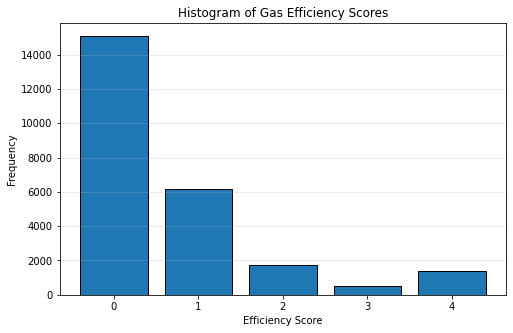

In [25]:
import matplotlib.pyplot as plt

df_pd = blocks_pl.select("efficiency_score").to_pandas()

# Plotting efficiency score
plt.figure(figsize=(8, 5))
plt.hist(df_pd["efficiency_score"], bins=range(6), edgecolor='black', align='left', rwidth=0.8)
plt.xticks(range(5))  # Since scores range from 0 to 4
plt.xlabel("Efficiency Score")
plt.ylabel("Frequency")
plt.title("Histogram of Gas Efficiency Scores")
plt.grid(axis='y', alpha=0.3)
plt.show()
